<a href="https://colab.research.google.com/github/SergioLucasINT/inteli-m09-gridworld/blob/main/gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classes

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Inputs

class Inputs:

  def __init__(self, height, width, mountains, quicksand, min_goal_distance, max_recombinations, gamma):

    self.height = height
    self.width = width
    self.mountains = mountains
    self.quicksand = quicksand
    self.min_goal_distance = min_goal_distance
    self.max_recombinations = max_recombinations
    self.gamma = gamma

  def verification(self):

    max_goal_distance = (self.width - 1) + (self.height - 1)

    if self.min_goal_distance > max_goal_distance:
        raise ValueError("A distância mínima ao objetivo é maior que a distância máxima possível nesse grid.")

    total_hazards = self.mountains + self.quicksand

    max_possible_hazards = self.height * self.width - 2

    if total_hazards > max_possible_hazards:
        raise ValueError(f"Não é possível instanciar {self.mountains} montanhas e {self.quicksand} areias movediças em um grid de {height}x{width}.")

## Environment

class Environment:

    def __init__(self, inputs):

      self.reference_grid = np.zeros((height, width), dtype="object")
      self.value_grid =  np.zeros((height, width))
      self.starting_point = []
      self.end_point = []
      self.inputs = inputs


    def create_hazards(self, hazard, quantity):

      while quantity > 0:

        x = random.randint(0, width - 1)

        y = random.randint(0, height - 1)

        if self.reference_grid[y][x] == 0:

          self.reference_grid[y][x] = hazard

          quantity -= 1


    def start_and_finish(self):

      height, width = self.reference_grid.shape

      for recombination in range(self.inputs.max_recombinations):

        start_y, start_x = random.randint(0, height - 1), random.randint(0, width - 1)

        if self.reference_grid[start_y][start_x] == 0:

          for attempt in range(height * width):

            end_y, end_x = random.randint(0, height - 1), random.randint(0, width - 1)

            if self.reference_grid[end_y][end_x] == 0:

              goal_distance = abs(start_y - end_y) + abs(start_x - end_x)

              if goal_distance >= self.inputs.min_goal_distance:

                self.reference_grid[start_y][start_x] = "I" # Inicio

                self.reference_grid[end_y][end_x] = "F" # Final

                self.starting_point = [start_y, start_x]

                self.end_point = [end_y, end_x]

                return

      raise ValueError("Não foi possível obter uma combinação válida entre pontos inicial e final no limite proposto.")

    def validate_grid(self):

        height, width = self.reference_grid.shape

        path_grid = np.zeros((height, width))

        path_grid[self.starting_point[0]][self.starting_point[1]] = 1

        visited = [[self.starting_point[0], self.starting_point[1]]]

        queue = [[self.starting_point[0], self.starting_point[1]]]

        while queue:

            current_node = queue.pop(0)

            y, x = current_node

            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                new_y, new_x = y + dy, x + dx
                if 0 <= new_y < height and 0 <= new_x < width:
                    if self.reference_grid[new_y][new_x] not in ['M', 'A'] and [new_y, new_x] not in visited:
                        path_grid[new_y][new_x] = 1
                        visited.append([new_y, new_x])
                        queue.append([new_y, new_x])

        if path_grid[self.end_point[0]][self.end_point[1]] == 1:
            return True
        else:
            return False

    def set_value_grid(self):

      height, width = self.value_grid.shape

      for y in range(height):

        for x in range(width):

            if self.reference_grid[y][x] == 'M':

                self.value_grid[y][x] = None

            elif self.reference_grid[y][x] == 'A':

                self.value_grid[y][x] = -10

            elif self.reference_grid[y][x] == 'F':

                self.value_grid[y][x] = 10

    def reward(self, y, x):

      if self.reference_grid[y][x] == 'A':

          return -10

      elif self.reference_grid[y][x] == 'F':

          return 10

      else:

          return 0

    def state_transition(self, y, x, action):

      new_y, new_x = y, x

      height, width = self.value_grid.shape

      if action == "up" and y > 0:

          new_y -= 1

      elif action == "down" and y < height - 1:

          new_y += 1

      elif action == "left" and x > 0:

          new_x -= 1

      elif action == "right" and x < width - 1:

          new_x += 1

      if self.reference_grid[new_y][new_x] in ['M', 'A']:

          return y, x

      return new_y, new_x

## Agent

class Agent:
    def __init__(self, environment):

        height, width = environment.value_grid.shape

        self.policy = np.random.choice(['up', 'down', 'left', 'right'], size=(height, width))

        self.gamma = environment.inputs.gamma

    def choose_action(self, y, x):

        return self.policy[y][x]

class Visualization:
    def __init__(self, environment, agent):
        self.environment = environment
        self.agent = agent

    def draw_optimal_path(self, ax, starting_point):
        y, x = starting_point
        ax.scatter(x, y, color='blue', s=100, zorder=5)
        while self.environment.reference_grid[y][x] != 'F':
            action = self.agent.choose_action(y, x)
            new_y, new_x = self.environment.state_transition(y, x, action)
            ax.plot([x, new_x], [y, new_y], color='red', linewidth=2, zorder=0)
            y, x = new_y, new_x
            if self.environment.reference_grid[y][x] in ['M', 'A']:
                break

    def draw_grid(self, starting_point):
        height, width = self.environment.value_grid.shape
        color_map = {'M': 'black', 'A': 'red', 'F': 'green', 'I': 'blue', 0: 'white'}
        policy_map = {'up': '^', 'down': 'v', 'left': '<', 'right': '>'}
        fig, ax = plt.subplots(figsize=(height, width))
        for y in range(height):
            for x in range(width):
                state = self.environment.reference_grid[y][x]
                color = color_map.get(state, 'white')
                ax.scatter(x, y, color=color, s=100)
                if state == 0:
                    action = self.agent.choose_action(y, x)
                    ax.text(x, y, policy_map[action], ha='center', va='center', color='gray')
        ax.set_xlim(-0.5, width-0.5)
        ax.set_ylim(-0.5, height-0.5)
        ax.set_xticks(range(width))
        ax.set_yticks(range(height))
        ax.grid(which='both')
        plt.gca().invert_yaxis()
        self.draw_optimal_path(ax, starting_point)
        plt.show()


# Iterative Policy

In [ ]:
def policy_evaluation(agent, environment, theta=0.1):
    height, width = environment.value_grid.shape
    while True:
        delta = 0
        for y in range(height):
            for x in range(width):
                v = environment.value_grid[y][x]
                action = agent.choose_action(y, x)
                new_y, new_x = environment.state_transition(y, x, action)
                reward = environment.reward(new_y, new_x)
                environment.value_grid[y][x] = reward + agent.gamma * environment.value_grid[new_y][new_x]
                delta = max(delta, abs(v - environment.value_grid[y][x]))
        if delta < theta:
            break

def policy_improvement(agent, environment):
    policy_stable = True
    height, width = environment.value_grid.shape
    for y in range(height):
        for x in range(width):
            old_action = agent.choose_action(y, x)
            action_values = []
            for action in ['up', 'down', 'left', 'right']:
                new_y, new_x = environment.state_transition(y, x, action)
                reward = environment.reward(new_y, new_x)
                action_value = reward + agent.gamma * environment.value_grid[new_y][new_x]
                action_values.append(action_value)
            best_action = ['up', 'down', 'left', 'right'][action_values.index(max(action_values))]
            agent.policy[y][x] = best_action
            if old_action != best_action:
                policy_stable = False
    return policy_stable

# Testes

Iteração: 1, Policy estável: False
Iteração: 2, Policy estável: False
Iteração: 3, Policy estável: False
Iteração: 4, Policy estável: False
Iteração: 5, Policy estável: False
Iteração: 6, Policy estável: False
Iteração: 7, Policy estável: False
Iteração: 8, Policy estável: False
Iteração: 9, Policy estável: False
Iteração: 10, Policy estável: False
Iteração: 11, Policy estável: False
Iteração: 12, Policy estável: True


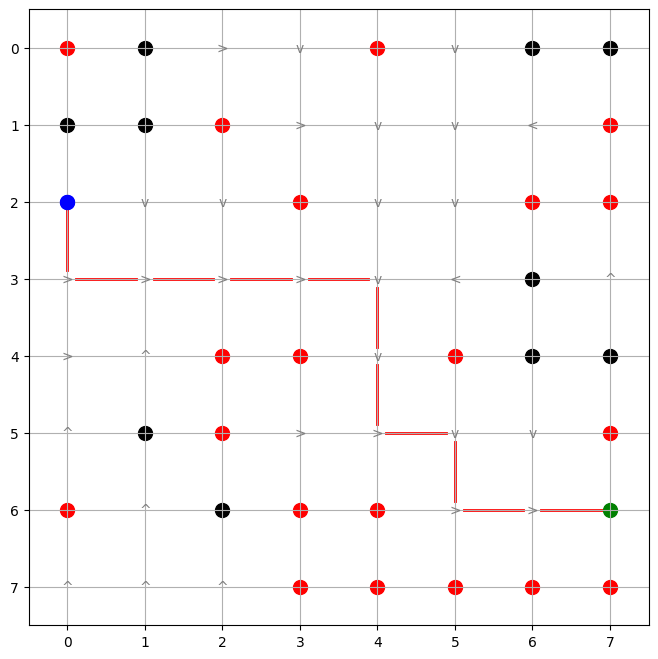

In [ ]:
height = 8 # @param {type:"integer"}, Altura do grid

width = 8 # @param {type:"integer"}, Largura do grid

mountains = 10 # @param {type:"integer"}, Número de montanhas a serem instanciadas.

quicksand = 20 # @param {type:"integer"}, Número de areias movediças a serem instanciadas.

min_goal_distance = 10 # @param {type:"integer"}, Número mínimo de distância entre o início e fim.

max_recombinations = 10 # @param {type:"integer"}, Número máximo de recombinações até o sistema desistir.

gamma = 0.9 # @param {type:"number"}, fator gama do cálculo de Iterative Policy

inputs = Inputs(height, width, mountains, quicksand, min_goal_distance, max_recombinations, gamma)

inputs.verification()

possible_grid = False

while possible_grid == False:

  environment = Environment(inputs)

  environment.create_hazards('M', inputs.mountains)

  environment.create_hazards('A', inputs.quicksand)

  environment.start_and_finish()

  possible_grid = Environment.validate_grid(environment)

environment.set_value_grid()

agent = Agent(environment)

policy_stable = False
iteration = 0
while not policy_stable:
    policy_evaluation(agent, environment)
    policy_stable = policy_improvement(agent, environment)
    iteration += 1
    print(f'Iteração: {iteration}, Policy estável: {policy_stable}')

environment.set_value_grid()

# Visualization
visualization = Visualization(environment, agent)
visualization.draw_grid(environment.starting_point)